# CIFAR10 Image Classification using CNN in Pytorch
> Assignment 5 of Artificial Intelligence course<br>
**Sadaf Sadeghian**<br>
810195419






In [0]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms

In [0]:
def initWeightsToZero(m):
  if type(m) == nn.Linear:
    m.bias.data.fill_(0)
    m.weight.data.fill_(0)

In [0]:
def evaluateNetwork(Net, normalize=False, batchSize=32, zeroWeight=False, learningRate=0.01, outputType="ephocText", momentum_=0.9):

  trans = [
      transforms.ToTensor(), 
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))    
  ]
  transform = transforms.Compose(trans if normalize else [trans[0]])
  

  cifar = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
  cifarTestSet = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
  
  split = int(0.8 * len(cifar))
  indexes = list(range(len(cifar)))
  trainIndexes, validationIndexes = indexes[:split], indexes[split:]

  # sampler objects
  trainSampler = SubsetRandomSampler(trainIndexes)
  validationSampler = SubsetRandomSampler(validationIndexes)

  # iterator objects
  trainLoader = DataLoader(cifar, batch_size=batchSize, sampler=trainSampler)
  validationLoader = DataLoader(cifar, batch_size=batchSize, sampler=validationSampler)
  testLoader = DataLoader(cifarTestSet, batch_size=batchSize)

  classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
  
  # loss function
  lossFunction = nn.CrossEntropyLoss()
  
  network = Net()
  if(zeroWeight):
    network.apply(initWeightsToZero)

  # optimizer
  optimizer = optim.SGD(network.parameters(), lr=learningRate, momentum=momentum_)
  
  start_time = time.time()
  batchNum = 0
  trainBatchLoss, batchNums = [], []
  for epoch in range(5):
    trainLoss, validLoss = [], []

    ### Train
    for data, target in trainLoader:
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward Propagation
        output = network(data)

        # compute loss
        loss = lossFunction(output, target)

        # back propagation
        loss.backward()

        # update parameters
        optimizer.step()

        trainLoss.append(loss.item())
        
        batchNum += 1
        if((batchNum % 20) == 0 and outputType=="batchPlot"):
          trainBatchLoss.append(np.mean(trainLoss))
          batchNums.append(batchNum)
          trainLoss = []

    ### Validation
    for data, target in validationLoader:

        output = network(data)
        loss = lossFunction(output, target)
        validLoss.append(loss.item())
    
    if(outputType == "ephocText"):  
      print("Epoch:", epoch+1, "|Training Loss: ", np.mean(trainLoss), "|Validation Loss: ", np.mean(validLoss))
    else:
      print("Epoch:", epoch+1, "|Validation Loss: ", np.mean(validLoss))
      

  if(outputType=="batchPlot"):
    plt.plot(batchNums, trainBatchLoss)
    plt.xlabel("Batch Number")
    plt.ylabel("Train Loss")
    plt.show
    
  elapsedTime = time.time() - start_time
  print("Training time:", elapsedTime)
  
  ### Test
  correct = 0
  total = 0
  with torch.no_grad():
      for data, target in testLoader:

          output = network(data)
          _, predicted = torch.max(output.data, 1)
          total += target.size(0)
          correct += (predicted == target).sum().item()

  print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

## 1) Effect of Weights and Biases Initialization in Neural Network

In [0]:
  class Net1(nn.Module):

      def __init__(self):
          super(Net1, self).__init__()

          self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
          self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
          self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

          self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 

          self.linear1 = nn.Linear(64 * (4 * 4), 512)
          self.linear2 = nn.Linear(512, 10)

      def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x)))
          x = self.pool(F.relu(self.conv3(x)))

          x = x.view(-1, 1024)  ## reshaping

          x = F.relu(self.linear1(x))
          x = self.linear2(x)
          return x

### Zero Weight Network

In [0]:
evaluateNetwork(Net=Net1, zeroWeight=True)

0it [00:00, ?it/s]

100%|█████████▉| 170434560/170498071 [00:32<00:00, 4670545.55it/s]

Files already downloaded and verified


170500096it [00:50, 4670545.55it/s]                               

Epoch: 1 |Training Loss:  2.3034087516784667 |Validation Loss:  2.30338269300735
Epoch: 2 |Training Loss:  2.303220442199707 |Validation Loss:  2.302892026048118
Epoch: 3 |Training Loss:  2.3034199333190917 |Validation Loss:  2.303008378123323
Epoch: 4 |Training Loss:  2.3033737691879272 |Validation Loss:  2.3028563394333226
Epoch: 5 |Training Loss:  2.3032839889526366 |Validation Loss:  2.303188312548799
Training time: 259.6043703556061
Accuracy of the network on the test images: 10 %


### Network with Random Weights

In [0]:
evaluateNetwork(Net=Net1)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 |Training Loss:  1.8007492104530334 |Validation Loss:  1.4265289839845114
Epoch: 2 |Training Loss:  1.3270365458488464 |Validation Loss:  1.2452350757754267
Epoch: 3 |Training Loss:  1.1023916879177094 |Validation Loss:  1.0842122012814774
Epoch: 4 |Training Loss:  0.9363559620857239 |Validation Loss:  1.0184609882366924
Epoch: 5 |Training Loss:  0.8128979505062103 |Validation Loss:  0.9249930377014148
Training time: 252.46883487701416
Accuracy of the network on the test images: 67 %




---


As shown above when weights and bias of network is set to zero, the accuracy is really low(10%).</br>
It is because when you have zero weight and bias in all layers, in the first layer activation will be zero or very small, as each noron output after applying bias and weights on sample inputs  will be zero and after applying activation function on zero it will remain zero or close to it. This happends in next layers too and activations of following layers will get nearer to zero. Hence this will lead to no or very few activations and extremely small gradient decents in back propagation. Extremely small gradient decents in back propagation lead to no or negligible update on weights so loss does not decrease and accuracy can not boost up.<br>
On the other hand, initializing weights and biases randomly as pytorch does by default will fix the problem stated before hence the network can decrease loss and increase accuracy significantly during training and achieve a high accuracy (67%).

## 2) Two Layer Network

In [0]:
class Net2(nn.Module):

    def __init__(self):
        super(Net2, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5)
        
        self.linear1 = nn.Linear(16 * (28 * 28), 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        
        x = x.view(-1, 16 * (28 * 28))  ## reshaping

        x = self.linear1(x)
        return x

In [0]:
evaluateNetwork(Net=Net2, learningRate=0.001)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 |Training Loss:  1.8041128494262695 |Validation Loss:  1.6197399258994447
Epoch: 2 |Training Loss:  1.4799123482227325 |Validation Loss:  1.4300466250306882
Epoch: 3 |Training Loss:  1.3764644934654235 |Validation Loss:  1.3791416403584587
Epoch: 4 |Training Loss:  1.324451096534729 |Validation Loss:  1.3640899328758922
Epoch: 5 |Training Loss:  1.287083025121689 |Validation Loss:  1.3530537739348487
Training time: 99.09717416763306
Accuracy of the network on the test images: 52 %




---


As number of convolution layers and fully connected layers are less in this 2 layer network(one convolution layer and one output layer which is a fully connected layer), training and processes on data is not as advance and accurate as the first network and as the result we have a network with smaller accuracy (52%) and higher loss.

## 3) Network with Normalization

In [0]:
evaluateNetwork(Net=Net1, normalize=True)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 |Training Loss:  1.6318812184333802 |Validation Loss:  1.265738382507056
Epoch: 2 |Training Loss:  1.1342535645961762 |Validation Loss:  1.0213625400591964
Epoch: 3 |Training Loss:  0.9116428291082382 |Validation Loss:  0.8970799268053743
Epoch: 4 |Training Loss:  0.767465466761589 |Validation Loss:  0.9254541628467389
Epoch: 5 |Training Loss:  0.6541620981574059 |Validation Loss:  0.8615348025823173
Training time: 274.42339992523193
Accuracy of the network on the test images: 70 %




---

Accuracy of network with normalization on input data will increase to 70% as normalized data make the optimization of network much easier and training more efficient. 
Because when different features do not have similar ranges of values, gradient can oscillate back and forth and take a long time to find its way to the minimum. In this case in the same time(5 epochs) network  converges more on normalized data.</br>
Training time increased in this case but generally normalization will decrease the training time as the computation on features when they are in same ranges will be easier thus requires less time for training.

## 4) Effect of Learning Rate on Network

### high learning rate

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 |Validation Loss:  1.7008870725814527
Epoch: 2 |Validation Loss:  1.6820313820061974
Epoch: 3 |Validation Loss:  1.7564301814514989
Epoch: 4 |Validation Loss:  1.766878911862358
Epoch: 5 |Validation Loss:  1.7785784684050197
Training time: 262.58147072792053
Accuracy of the network on the test images: 35 %


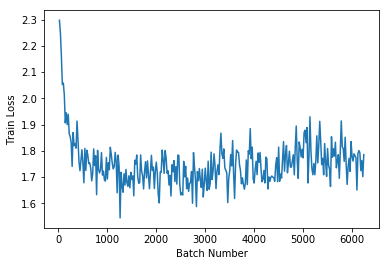

In [0]:
evaluateNetwork(Net=Net1, normalize=True, learningRate=0.07, outputType="batchPlot")



---

High learning rate means we travel along the downward slope in large steps and because of that we can not get close to the minimum more than a specific value because the step size is larger than our distance from minima and after that amount, we go far from minimum and increases the loss and as the result we can observe that network fails to converge.<br>
![alt text](https://cdn-images-1.medium.com/max/1600/0*00BrbBeDrFOjocpK.)

### good learning rate

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 |Validation Loss:  1.3052531023756764
Epoch: 2 |Validation Loss:  1.0275526244800313
Epoch: 3 |Validation Loss:  0.9210575520992279
Epoch: 4 |Validation Loss:  0.8568399248603052
Epoch: 5 |Validation Loss:  0.8584645741378156
Training time: 271.0380771160126
Accuracy of the network on the test images: 70 %


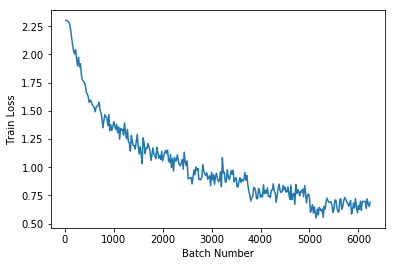

In [0]:
evaluateNetwork(Net=Net1, normalize=True, learningRate=0.01, outputType="batchPlot")



---

With a good learning rate, we move towards minima with apropriate step size and enventually networks reachs the minimum and after that the loss remains approximately the same. As the result, it converges to local minima more quickly and needs less time for training and the loss dicreases more than two other cases so the best accuracy will be reached with this step size.

### low learning rate

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 |Validation Loss:  2.2988300582471366
Epoch: 2 |Validation Loss:  2.293507007745127
Epoch: 3 |Validation Loss:  2.2846795370022708
Epoch: 4 |Validation Loss:  2.2658587438991655
Epoch: 5 |Validation Loss:  2.2146633547335006
Training time: 272.2673370838165
Accuracy of the network on the test images: 22 %


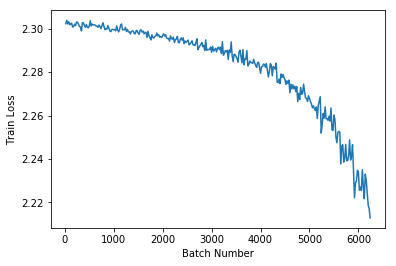

In [0]:
evaluateNetwork(Net=Net1, normalize=True, learningRate=0.0001, outputType="batchPlot")



---

Low learning rate means that we are moving along downward slope with very small step size and because of that it takes a lot of time to reduce loss and we spend more time far from minima and searching for it in comparison with a good learning rate. As you can see above, small step size will not let the loss to decrease enough in 5 epoches and after our training the loss lessened for a small amount and it is still a big amount for loss(2.21).

## 5) Effect of Batch Size on Network

### batch size = 64

with learning rate = 0.01(default value and as it was before)

In [0]:
evaluateNetwork(Net=Net1, normalize=True, batchSize=64)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 |Training Loss:  1.7889031579971313 |Validation Loss:  1.422423954981907
Epoch: 2 |Training Loss:  1.2913023562431336 |Validation Loss:  1.1905038702260158
Epoch: 3 |Training Loss:  1.0531460809707642 |Validation Loss:  1.0341583475185807
Epoch: 4 |Training Loss:  0.9085641683578491 |Validation Loss:  0.9357685572022845
Epoch: 5 |Training Loss:  0.7908004652500152 |Validation Loss:  0.8493366108578482
Training time: 250.8223271369934
Accuracy of the network on the test images: 70 %


with learning rate = 0.05

In [0]:
evaluateNetwork(Net=Net1, normalize=True, batchSize=64, learningRate=0.05)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 |Training Loss:  1.5896427129745483 |Validation Loss:  1.257612699156354
Epoch: 2 |Training Loss:  1.163565060043335 |Validation Loss:  1.1294949309081788
Epoch: 3 |Training Loss:  1.0276961307525634 |Validation Loss:  1.0557689552853822
Epoch: 4 |Training Loss:  0.9302632021427154 |Validation Loss:  1.0688918582193412
Epoch: 5 |Training Loss:  0.8714286916255951 |Validation Loss:  1.171356332529882
Training time: 245.6736147403717
Accuracy of the network on the test images: 61 %


### batch size = 256

with learning rate = 0.01 (default value and as it was before)

In [0]:
evaluateNetwork(Net=Net1, normalize=True, batchSize=256)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 |Training Loss:  2.191500560493226 |Validation Loss:  1.9633248269557952
Epoch: 2 |Training Loss:  1.7911584028013192 |Validation Loss:  1.6461790055036545
Epoch: 3 |Training Loss:  1.5512089304103973 |Validation Loss:  1.4917387455701827
Epoch: 4 |Training Loss:  1.3945331786088884 |Validation Loss:  1.4139004230499268
Epoch: 5 |Training Loss:  1.275004750604083 |Validation Loss:  1.222489106655121
Training time: 236.6599543094635
Accuracy of the network on the test images: 56 %


with learning rate = 0.1

In [0]:
evaluateNetwork(Net=Net1, normalize=True, batchSize=256, learningRate=0.1)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 |Training Loss:  1.802912678688195 |Validation Loss:  1.3426841378211976
Epoch: 2 |Training Loss:  1.2493421849171826 |Validation Loss:  1.1454534500837326
Epoch: 3 |Training Loss:  1.0586192262400487 |Validation Loss:  1.0731780290603639
Epoch: 4 |Training Loss:  0.9040429352954694 |Validation Loss:  1.0075796008110047
Epoch: 5 |Training Loss:  0.7724812983707258 |Validation Loss:  0.9266105845570565
Training time: 229.06286644935608
Accuracy of the network on the test images: 68 %




---


We can observe that higher batch sizes lead to lower test accuracy.Network has 70% accuracy for batch size of 32 and 64, but for batch size of 256 accuracy reduces to 56%.  <br>
Higher batch sizes cons:
*   Large batch size leads to slower convergence to that optima in comparison with smaller batch sizes so network will have a slower training with large batch sizes
*   Too large batch size will lead to poor generalization and perhaps overfitting. Because it seems that higher variance gradients of minibatch gradient descent actually being tied to generalization.

Higher batch sizes pros:
*   With small batch sizes, the model is not guaranteed to converge to the global optima because It will bounce around the global optima but Larger minibatch size means more "accurate" gradients and being closer to the "true" gradient 
* Small batch results in rapid learning but a volatile learning process with higher variance in the accuracy. Larger batch sizes slow down the learning process but the final stages result in a convergence to a more stable model 

With increasing the learning rate, we can recover the low accuracy caused by using a larger batch size. With 256 for batch size we achieve 56% accuracy when learning rate equals to 0.01 but this value increases to 68% for learning rate of 0.1 which is a huge improvement.<br>
I think it is because with larger batch sizes gradients will be accurate, thus you can take larger steps without detriment and loss.

## 6) Different Activation Functions

### tanh

In [0]:
class Net_tanh(nn.Module):

    def __init__(self):
        super(Net_leakyRelu, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.linear1 = nn.Linear(64 * (4 * 4), 512)
        self.linear2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.conv3(x)))

        x = x.view(-1, 1024)  ## reshaping

        x = F.leaky_relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [0]:
evaluateNetwork(Net=Net_ackFunc, normalize=True)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 |Training Loss:  1.5954821367263794 |Validation Loss:  1.3095929436028575
Epoch: 2 |Training Loss:  1.0940746612548828 |Validation Loss:  1.0159024099191538
Epoch: 3 |Training Loss:  0.8947905774593353 |Validation Loss:  0.9190141938555355
Epoch: 4 |Training Loss:  0.7533263073444366 |Validation Loss:  0.8514402927682042
Epoch: 5 |Training Loss:  0.6467311169266701 |Validation Loss:  0.9040699112720002
Training time: 268.95976734161377
Accuracy of the network on the test images: 69 %




---


![alt text](https://cdn-images-1.medium.com/max/1200/1*51Q7QouspCkOvENni2RwfQ.png)
<br>
Hyper bolic Tangent function gives us less accuracy. This function as an activation function suffer from the 'vanishing gradient problem' because as you can see the value of function changes slightly towards the ends of function which will cause derivatives to be very small in this regions and converge to zero. As the result even if the input of neuron differs hugely in this region, its output will not change or changes for an extremely small value. Vanishing problem can lead to minimal or zero leaning as there will be no update in weights.<br>
Generally, the calculation with this function is more than a simple function and leads to more time for training.

### ReLU

In [0]:
evaluateNetwork(Net=Net1, normalize=True)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 |Training Loss:  1.6489029582500458 |Validation Loss:  1.2885131675976154
Epoch: 2 |Training Loss:  1.141836962556839 |Validation Loss:  1.0233613999126057
Epoch: 3 |Training Loss:  0.9366183966636658 |Validation Loss:  0.942835420465317
Epoch: 4 |Training Loss:  0.7951607717514038 |Validation Loss:  0.8670361360993248
Epoch: 5 |Training Loss:  0.6696334651947021 |Validation Loss:  0.8247657887661419
Training time: 269.4092044830322
Accuracy of the network on the test images: 70 %




---

![alt text](https://cdn-images-1.medium.com/max/1200/1*m_0v2nY5upLmCU-0SuGZXg.png)
<br>
ReLU function is a good estimator because it is possible to converge with any function by combinations of ReLU.<br>
As you can see we have the value of 0 on the negative axis which can have a positive and a negative effect on network :<br>

**(+)Sparcity**
Having the value of 0 on the negative axis means that some neurons will not activate. Sparsity results better predictive power and less overfitting. In a sparse network, it’s more probable that neurons are processing meaningful aspects of the problem so the model will be more concise. Also as the result of less activations, the calculation load is less thus the network will run faster.<br>

**(-)Dying ReLU**
Slope of ReLU in the negative range is also 0, So once a neuron gets negative, it’s unlikely for it to recover. A ReLu neuron is called 'dead' if it always outputs 0 because of getting stuck in negative side. Learning is not happening in this area and dead neurons will not play any role in processing the input.
The dying problem is likely to occur when there is a large negative bias.

### leakyrelu

In [0]:
class Net_leakyRelu(nn.Module):

    def __init__(self):
        super(Net_leakyRelu, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.linear1 = nn.Linear(64 * (4 * 4), 512)
        self.linear2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.conv3(x)))

        x = x.view(-1, 1024)  ## reshaping

        x = F.leaky_relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [0]:
evaluateNetwork(Net=Net_leakyRelu, normalize=True)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 |Training Loss:  1.6585179952144622 |Validation Loss:  1.3472920557180532
Epoch: 2 |Training Loss:  1.1499838267803193 |Validation Loss:  1.0545802619129705
Epoch: 3 |Training Loss:  0.9314553303241729 |Validation Loss:  0.8723846346425553
Epoch: 4 |Training Loss:  0.7814177124500274 |Validation Loss:  0.9007532088139567
Epoch: 5 |Training Loss:  0.6613423487782478 |Validation Loss:  0.8623798191547394
Training time: 315.2214798927307
Accuracy of the network on the test images: 70 %




---

![alt text](https://cdn-images-1.medium.com/max/1200/1*gDIUV3yonKbIWh_9Kl4ShQ.png)
<br>
Leaky ReLU has a small slope for negative values, instead of altogether zero. As the result of that, we will no longer suffer from 'dying ReLU' problem.Also leaky ReLU is more balanced, and may therefore learn faster and gain a larger accuracy.<br>
Training time of leaky ReLU is more than ReLU because we have more computation using this function.

### softplus

In [0]:
class Net_softplus(nn.Module):
    
    def __init__(self):
        super(Net_softplus, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.linear1 = nn.Linear(64 * (4 * 4), 512)
        self.linear2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.softplus(self.conv1(x)))
        x = self.pool(F.softplus(self.conv2(x)))
        x = self.pool(F.softplus(self.conv3(x)))

        x = x.view(-1, 1024)  ## reshaping

        x = F.softplus(self.linear1(x))
        x = self.linear2(x)
        return x

In [0]:
evaluateNetwork(Net=Net_softplus, normalize=True)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 |Training Loss:  2.2085207825660707 |Validation Loss:  1.974759954233139
Epoch: 2 |Training Loss:  1.7062097623825074 |Validation Loss:  1.5492500200058326
Epoch: 3 |Training Loss:  1.4292797028064728 |Validation Loss:  1.389527882821263
Epoch: 4 |Training Loss:  1.2724703412532807 |Validation Loss:  1.2609665940363948
Epoch: 5 |Training Loss:  1.151931735610962 |Validation Loss:  1.1977429740345136
Training time: 730.3430860042572
Accuracy of the network on the test images: 58 %




---
![alt text](https://cdn-images-1.medium.com/max/1600/1*w275Sin5bKAIaWBaJ6zXcA.png)

ReLU and Softplus are largely similar, except near 0 where the softplus is smooth and differentiable.
It’s much easier and efficient to compute ReLU and its derivative than for the softplus function which has log and exp in its formulation. As computing the activation function and its derivative is as frequent in deep learning thus with using ReLU the forward and backward passes are much faster. So as you can see the training time using softplus is more than ReLU andthe accuracy decrease to 58%.

## 7) Effect of Momentum on SGD

### without momentum

In [0]:
evaluateNetwork(Net=Net1, normalize=True, momentum_=0)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 |Training Loss:  2.206315065193176 |Validation Loss:  1.9573718187527154
Epoch: 2 |Training Loss:  1.7846874520301819 |Validation Loss:  1.6372513397813986
Epoch: 3 |Training Loss:  1.5707276392936707 |Validation Loss:  1.5043304583515984
Epoch: 4 |Training Loss:  1.434236606168747 |Validation Loss:  1.3782472157249817
Epoch: 5 |Training Loss:  1.327245115852356 |Validation Loss:  1.2810725533543303
Training time: 267.7429630756378
Accuracy of the network on the test images: 53 %


![alt text](https://cdn-images-1.medium.com/max/1200/1*JHYIDkzf1ImuZK487q_kiw.gif)

### with momentum

In [0]:
evaluateNetwork(Net=Net1, normalize=True)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 |Training Loss:  1.6441562950611115 |Validation Loss:  1.3787087573410985
Epoch: 2 |Training Loss:  1.1420481600284575 |Validation Loss:  1.033905130605728
Epoch: 3 |Training Loss:  0.915047332572937 |Validation Loss:  0.9433187644321698
Epoch: 4 |Training Loss:  0.7774663432598115 |Validation Loss:  0.8638745463503816
Epoch: 5 |Training Loss:  0.6579337474942207 |Validation Loss:  0.8205470999780173
Training time: 268.9390833377838
Accuracy of the network on the test images: 71 %


![alt text](https://cdn-images-1.medium.com/max/1200/1*uTiP1uRl2CaHaA-dFu3NKw.gif)



---

As the results are shown above accuracy of network with momentum is higher and training times are approximately same.<br>
In SGD the exact derivate of our loss function is not computed, instead an estimation of it on a small batch is computed. As the result because this Derivatives are noisy, this will cause us not to always move in the optimal direction. <br>
Momentum which is an exponentially weighed average of our gradients can help us by denoising the data and bring it closer to the right direction and fix the problem we mentioned before for SGD.<br>
As the result SGD with momentum can provide us a better estimate of actual derivate thus it works better and faster than classic SGD. Momentum helps to accelerate gradient vectors in the right directions, leading to faster converging and less time for training also more accuracy will be achieved.